# Packages and variables

In [1]:
# Load packages
from sentence_transformers import models, losses, datasets, SentencesDataset
from sentence_transformers import SentenceTransformer, util, InputExample
import pandas as pd
import numpy as np
from datasets import load_dataset
from transformers import BertTokenizer
from sklearn.metrics.pairwise import cosine_similarity
import torch
from tqdm import tqdm
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.manifold import MDS

In [2]:
# Specify variables
model_name = "bert-base-uncased"
train_batch_size = 20
max_seq_length = 250
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained(model_name)

# Load and prepare dataset

In [3]:
# Load dataset from huggingface
dataset = load_dataset("multi_nli")

# and make dataset as dataframe for easier usage
df = pd.DataFrame()
df["premise"] = dataset["train"]["premise"]
df["hypothesis"] = dataset["train"]["hypothesis"]
df["genre"] = dataset["train"]["genre"]
df["label"] = dataset["train"]["label"]

df_test = pd.DataFrame()
df_test["premise"] = dataset["validation_matched"]["premise"]
df_test["hypothesis"] = dataset["validation_matched"]["hypothesis"]
df_test["genre"] = dataset["validation_matched"]["genre"]
df_test["label"] = dataset["validation_matched"]["label"]

Found cached dataset multi_nli (/home/jupyter/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39)


  0%|          | 0/3 [00:00<?, ?it/s]

# Test Triplet

In [4]:
# load triplet model
model = SentenceTransformer("model_triplet_mnli", device="cuda")

# find average embeddings of positive and negative clusters from a sample (100) of training data
# we use a very small sample here as later the mds algorithm is quite slow even with few data
# but 100 data samples is still enough to find the cluster centers
clusters = {}
# saving data for visualization too
all_data = np.empty((0,768), float)
labs = []
genres = []

for genre in ["telephone","government","travel","fiction","slate"]:
    print(genre)
    for label in range(3):
        n = 0
        mean_embedding = np.zeros(768)
        tmp_dataset = df[(df["genre"]==genre) & (df["label"]==label)].sample(100)

        for _, row in tmp_dataset.iterrows():
            emb = model.encode(row["premise"] + " " + tokenizer.sep_token + " " + row["hypothesis"])
            mean_embedding += emb
            all_data = np.append(all_data, emb.reshape(-1,768), axis=0)
            genres.append(row["genre"])
            labs.append(row["label"])
            n += 1

        clusters[genre + str(label)] = mean_embedding/n
        
# get error as average between positive prediction and negative prediction
error = {}
n = {}
for _, row in tqdm(df_test.iterrows()):
    genre = row["genre"]
    lab = row["label"]
    emb = model.encode(row["premise"] + " " + tokenizer.sep_token + " " + row["hypothesis"])
    if genre not in error:
        error[genre] = 0
        n[genre] = 0
    
    # get cosine similarity with positive and negative clusters for the genre
    # when testing should be done with each class to get prediction of each genre
    posi = cosine_similarity(emb.reshape(-1, 768), clusters[genre + str(0)].reshape(-1, 768))[0][0]
    nega = cosine_similarity(emb.reshape(-1, 768), clusters[genre + str(2)].reshape(-1, 768))[0][0]

    # 0 is positive (entailment)
    if lab == 0:
        true = 1
    # 1 is neutral
    elif lab == 1:
        true = 0
    # 2 is negative (contradiction)
    else:
        true = -1
    error[genre] += abs(true - (posi-nega)/2)
    n[genre] += 1

for genre in ["telephone","government","travel","fiction","slate"]:        
    error[genre] /= n[genre]
    
print(error)

telephone
government
travel
fiction
slate


9815it [02:00, 81.12it/s]

{'slate': 0.6365350372468725, 'government': 0.6341338665533809, 'telephone': 0.6466280209932569, 'travel': 0.6329707038766553, 'fiction': 0.6471938392661143}


# Visualize Triplet

In [5]:
# get MDS 2d components
# this does take some time even with small samples
embedding = MDS(n_components=2, metric=True)
X = embedding.fit_transform(all_data)

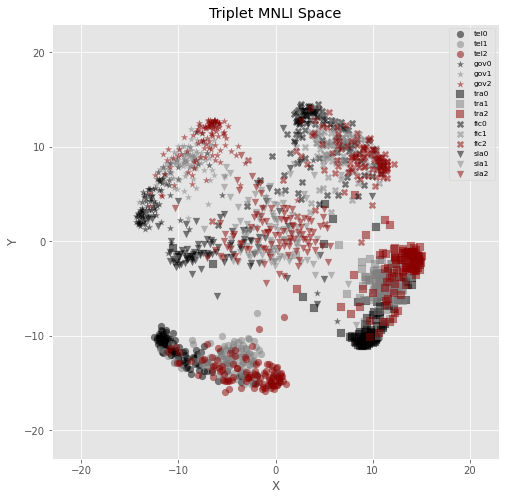

In [6]:
# plot the data
plt.style.use('ggplot')
fig, ax1 = plt.subplots(1, 1, figsize=(8,8))
colorlist = ["black","grey","darkred"]
markers = ["o","*","s","X","v"]

# prepare dataframe with data
plot_df = pd.DataFrame(zip(list(X[:, 0]), list(X[:, 1]), [genre[:3]+str(label) for genre,label in zip(genres,labs)]), columns=["X","Y","Genre"])
l_unq = plot_df['Genre'].unique()

for i, genre in enumerate(l_unq):
    x = plot_df[(plot_df.Genre==genre)].X
    y = plot_df[(plot_df.Genre==genre)].Y
    # color depends on polarity
    # marker depends on genre
    ax1.scatter(x, y, marker=markers[i//3], label=genre, s=50, linewidth=0.1, c=colorlist[int(genre[-1])], alpha=0.5)

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_xlim(-23, 23)
ax1.set_ylim(-23, 23)
ax1.legend(loc=1, prop={'size': 7.5})
ax1.set_title("Triplet MNLI Space")

plt.show()

# Test Adacos

In [7]:
# load triplet model
model = SentenceTransformer("model_adacos_mnli", device="cuda")

# find average embeddings of positive and negative clusters from a sample (100) of training data
# we use a very small sample here as later the mds algorithm is quite slow even with few data
# but 100 data samples is still enough to find the cluster centers
clusters = {}
# saving data for visualization too
all_data = np.empty((0,768), float)
labs = []
genres = []

for genre in ["telephone","government","travel","fiction","slate"]:
    print(genre)
    for label in range(3):
        n = 0
        mean_embedding = np.zeros(768)
        tmp_dataset = df[(df["genre"]==genre) & (df["label"]==label)].sample(100)

        for _, row in tmp_dataset.iterrows():
            emb = model.encode(row["premise"] + " " + tokenizer.sep_token + " " + row["hypothesis"])
            mean_embedding += emb
            all_data = np.append(all_data, emb.reshape(-1,768), axis=0)
            genres.append(row["genre"])
            labs.append(row["label"])
            n += 1

        clusters[genre + str(label)] = mean_embedding/n
        
# get error as average between positive prediction and negative prediction
error = {}
n = {}
for _, row in tqdm(df_test.iterrows()):
    genre = row["genre"]
    lab = row["label"]
    emb = model.encode(row["premise"] + " " + tokenizer.sep_token + " " + row["hypothesis"])
    if genre not in error:
        error[genre] = 0
        n[genre] = 0
    
    # get cosine similarity with positive and negative clusters for the genre
    # when testing should be done with each class to get prediction of each genre
    posi = cosine_similarity(emb.reshape(-1, 768), clusters[genre + str(0)].reshape(-1, 768))[0][0]
    nega = cosine_similarity(emb.reshape(-1, 768), clusters[genre + str(2)].reshape(-1, 768))[0][0]

    # 0 is positive (entailment)
    if lab == 0:
        true = 1
    # 1 is neutral
    elif lab == 1:
        true = 0
    # 2 is negative (contradiction)
    else:
        true = -1
    error[genre] += abs(true - (posi-nega)/2)
    n[genre] += 1

for genre in ["telephone","government","travel","fiction","slate"]:        
    error[genre] /= n[genre]
    
print(error)

telephone
government
travel
fiction
slate


9815it [02:03, 79.38it/s]

{'slate': 0.5895883721638338, 'government': 0.5634518904112379, 'telephone': 0.587974586142935, 'travel': 0.5734017014343152, 'fiction': 0.5653775288584613}


# Visualize AdaCos

In [8]:
# get MDS 2d components
# this does take some time even with small samples
embedding = MDS(n_components=2, metric=True)
X = embedding.fit_transform(all_data)

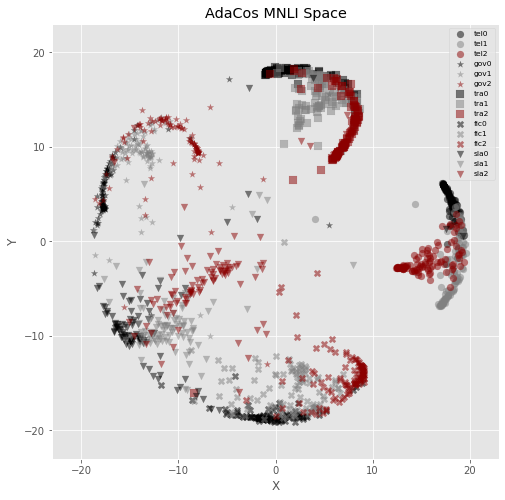

In [9]:
# plot the data
plt.style.use('ggplot')
fig, ax1 = plt.subplots(1, 1, figsize=(8,8))
colorlist = ["black","grey","darkred"]
markers = ["o","*","s","X","v"]

# prepare dataframe with data
plot_df = pd.DataFrame(zip(list(X[:, 0]), list(X[:, 1]), [genre[:3]+str(label) for genre,label in zip(genres,labs)]), columns=["X","Y","Genre"])
l_unq = plot_df['Genre'].unique()

for i, genre in enumerate(l_unq):
    x = plot_df[(plot_df.Genre==genre)].X
    y = plot_df[(plot_df.Genre==genre)].Y
    # color depends on polarity
    # marker depends on genre
    ax1.scatter(x, y, marker=markers[i//3], label=genre, s=50, linewidth=0.1, c=colorlist[int(genre[-1])], alpha=0.5)

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_xlim(-23, 23)
ax1.set_ylim(-23, 23)
ax1.legend(loc=1, prop={'size': 7.5})
ax1.set_title("AdaCos MNLI Space")

plt.show()

# Test Adacos + Pairwise

In [10]:
# load triplet model
model = SentenceTransformer("model_pairwise_mnli", device="cuda")

# find average embeddings of positive and negative clusters from a sample (100) of training data
# we use a very small sample here as later the mds algorithm is quite slow even with few data
# but 100 data samples is still enough to find the cluster centers
clusters = {}
# saving data for visualization too
all_data = np.empty((0,768), float)
labs = []
genres = []

for genre in ["telephone","government","travel","fiction","slate"]:
    print(genre)
    for label in range(3):
        n = 0
        mean_embedding = np.zeros(768)
        tmp_dataset = df[(df["genre"]==genre) & (df["label"]==label)].sample(100)

        for _, row in tmp_dataset.iterrows():
            emb = model.encode(row["premise"] + " " + tokenizer.sep_token + " " + row["hypothesis"])
            mean_embedding += emb
            all_data = np.append(all_data, emb.reshape(-1,768), axis=0)
            genres.append(row["genre"])
            labs.append(row["label"])
            n += 1

        clusters[genre + str(label)] = mean_embedding/n
        
# get error as average between positive prediction and negative prediction
error = {}
n = {}
for _, row in tqdm(df_test.iterrows()):
    genre = row["genre"]
    lab = row["label"]
    emb = model.encode(row["premise"] + " " + tokenizer.sep_token + " " + row["hypothesis"])
    if genre not in error:
        error[genre] = 0
        n[genre] = 0
    
    # get cosine similarity with positive and negative clusters for the genre
    # when testing should be done with each class to get prediction of each genre
    posi = cosine_similarity(emb.reshape(-1, 768), clusters[genre + str(0)].reshape(-1, 768))[0][0]
    nega = cosine_similarity(emb.reshape(-1, 768), clusters[genre + str(2)].reshape(-1, 768))[0][0]

    # 0 is positive (entailment)
    if lab == 0:
        true = 1
    # 1 is neutral
    elif lab == 1:
        true = 0
    # 2 is negative (contradiction)
    else:
        true = -1
    error[genre] += abs(true - (posi-nega)/2)
    n[genre] += 1

for genre in ["telephone","government","travel","fiction","slate"]:        
    error[genre] /= n[genre]
    
print(error)

telephone
government
travel
fiction
slate


9815it [02:02, 80.16it/s]

{'slate': 0.3768389869105728, 'government': 0.2515796470517013, 'telephone': 0.25127492387270844, 'travel': 0.2620006476967314, 'fiction': 0.28958368457664196}


# Visualize AdaCos + Pairwise

In [11]:
# get MDS 2d components
# this does take some time even with small samples
embedding = MDS(n_components=2, metric=True)
X = embedding.fit_transform(all_data)

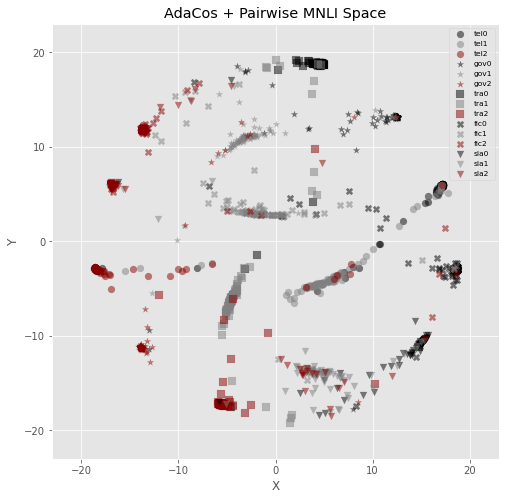

In [12]:
# plot the data
plt.style.use('ggplot')
fig, ax1 = plt.subplots(1, 1, figsize=(8,8))
colorlist = ["black","grey","darkred"]
markers = ["o","*","s","X","v"]

# prepare dataframe with data
plot_df = pd.DataFrame(zip(list(X[:, 0]), list(X[:, 1]), [genre[:3]+str(label) for genre,label in zip(genres,labs)]), columns=["X","Y","Genre"])
l_unq = plot_df['Genre'].unique()

for i, genre in enumerate(l_unq):
    x = plot_df[(plot_df.Genre==genre)].X
    y = plot_df[(plot_df.Genre==genre)].Y
    # color depends on polarity
    # marker depends on genre
    ax1.scatter(x, y, marker=markers[i//3], label=genre, s=50, linewidth=0.1, c=colorlist[int(genre[-1])], alpha=0.5)

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_xlim(-23, 23)
ax1.set_ylim(-23, 23)
ax1.legend(loc=1, prop={'size': 7.5})
ax1.set_title("AdaCos + Pairwise MNLI Space")

plt.show()